In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [3]:

df = pd.read_csv("/content/drive/MyDrive/gasscore/gas_score.csv")


df = df.drop(columns=["chronic_conditions", "sleep_hours"], errors="ignore")

# Target
y = df["gas_level"]

# Features
X = df.drop(columns=["id", "gas_level", "gas_total"], errors="ignore")
# X = df[[f"q{i:02d}" for i in range(1, 31)]]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [5]:
cat_cols = [c for c in X.columns if X[c].dtype == "object"]
num_cols = [c for c in X.columns if c not in cat_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols),
    ]
)


In [6]:
models = {
    "LogisticRegression": Pipeline([
        ("prep", preprocess),
        ("model", LogisticRegression(max_iter=3000))
    ]),
    "RandomForest": Pipeline([
        ("prep", preprocess),
        ("model", RandomForestClassifier(
           n_estimators=100,
            max_depth=10,
            min_samples_leaf=5,
            random_state=42,
            n_jobs=-1
        ))
    ])
}

In [7]:
accs = {}
preds = {}
probas = {}

for name, clf in models.items():
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    acc = accuracy_score(y_test, pred)

    accs[name] = acc
    preds[name] = pred

    # probabilities (needed for ROC)
    if hasattr(clf.named_steps["model"], "predict_proba"):
        probas[name] = clf.predict_proba(X_test)

    print(f"\n{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, pred))

best_name = max(accs, key=accs.get)
best_model = models[best_name]
print(f"\n✅ Best Model: {best_name} | Accuracy: {accs[best_name]:.4f}")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



LogisticRegression Accuracy: 0.9999
              precision    recall  f1-score   support

        mild       1.00      1.00      1.00      2500
     minimal       1.00      1.00      1.00      2500
    moderate       1.00      1.00      1.00      2500
      severe       1.00      1.00      1.00      2500

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000


RandomForest Accuracy: 0.9649
              precision    recall  f1-score   support

        mild       0.95      0.96      0.96      2500
     minimal       1.00      0.96      0.98      2500
    moderate       0.92      0.99      0.95      2500
      severe       1.00      0.95      0.97      2500

    accuracy                           0.96     10000
   macro avg       0.97      0.96      0.97     10000
weighted avg       0.97      0.96      0.97     10000


✅ Best Model: LogisticRegression | Accuracy: 0.9999


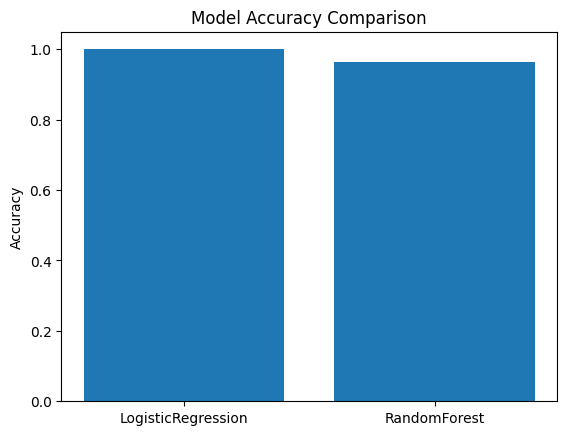

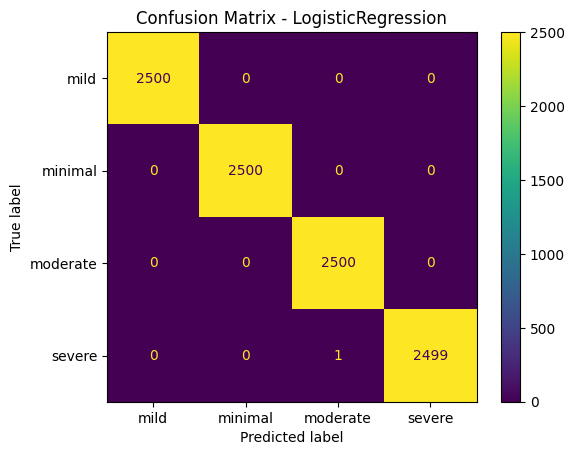

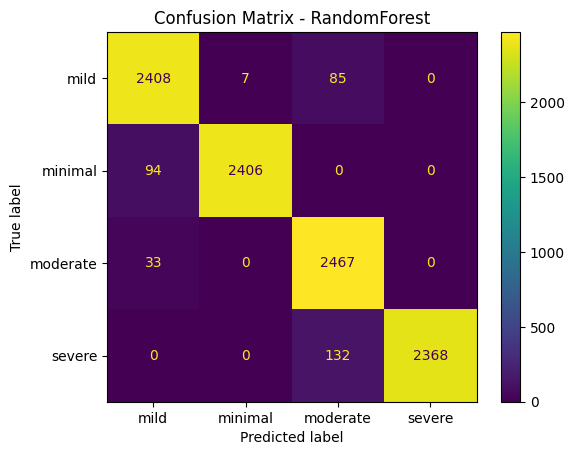

In [8]:
plt.figure()
plt.bar(list(accs.keys()), list(accs.values()))
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1.05)
plt.show()


labels = sorted(y.unique())

for name in models.keys():
    cm = confusion_matrix(y_test, preds[name], labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(values_format="d")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

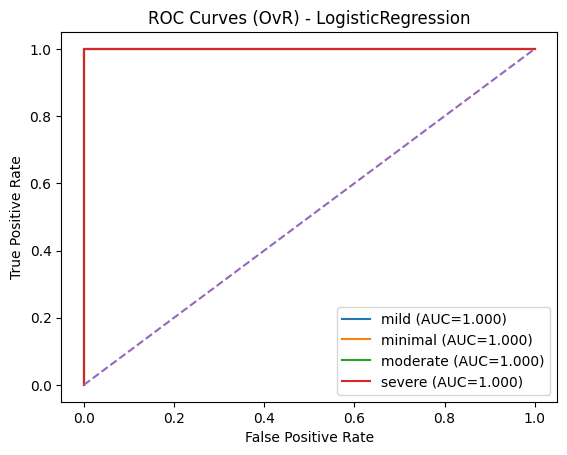

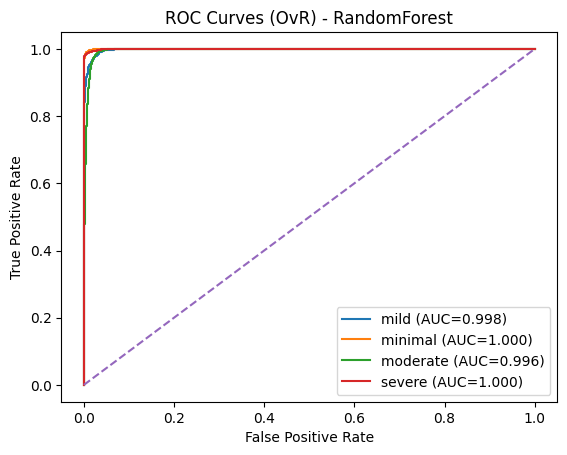

In [9]:

classes = labels
y_test_bin = label_binarize(y_test, classes=classes)

for name, prob in probas.items():
    plt.figure()
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{cls} (AUC={roc_auc:.3f})")

    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.title(f"ROC Curves (OvR) - {name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()


In [11]:
import joblib
import os

joblib.dump(models["RandomForest"], "/content/drive/MyDrive/gasscore/RandomForest_small.pkl", compress=3)



['/content/drive/MyDrive/gasscore/RandomForest_small.pkl']

In [13]:
import joblib
import pandas as pd

load_path = "/content/drive/MyDrive/gasscore/RandomForest_small.pkl"
model = joblib.load(load_path)

# Build example input
sample = pd.DataFrame([{
    "age": 70,
    "gender": "female",
    "lives_alone": 0,
    **{f"q{i:02d}": 1 for i in range(1, 31)}
}])

# --- compute sums (MUST match training) ---
q_cols = [f"q{i:02d}" for i in range(1, 31)]

sample["cognitive_sum"] = sample[[f"q{i:02d}" for i in range(1, 11)]].sum(axis=1)     # q01-q10
sample["somatic_sum"]   = sample[[f"q{i:02d}" for i in range(11, 21)]].sum(axis=1)    # q11-q20
sample["affective_sum"] = sample[[f"q{i:02d}" for i in range(21, 31)]].sum(axis=1)    # q21-q30

# Predict
prediction = model.predict(sample)
proba = model.predict_proba(sample)

print("Predicted gas_level:", prediction[0])
print("Class probabilities:", dict(zip(model.classes_, proba[0])))


Predicted gas_level: moderate
Class probabilities: {'mild': np.float64(0.04251463336766968), 'minimal': np.float64(0.00011040462427745664), 'moderate': np.float64(0.8495030818868661), 'severe': np.float64(0.10787188012118712)}
